In [114]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from ensemble.generate import generate
import starry
from starry_process import StarryProcess
import theano
import theano.tensor as tt
import os
from tqdm.notebook import tqdm

In [9]:
runid = 1
PATH = "ensemble"
DATA_FILE = os.path.join(PATH, "{:02d}".format(runid), "data.npz")
TRUTH_FILE = os.path.join(PATH, "{:02d}".format(runid), "truth.npz")
data, truth = generate(runid)
t = data["t"]
flux = data["flux"]
ferr = data["ferr"]
nlc = len(flux)
baseline_var = 1e-2

Pre-computing some matrices... Done.
  0%|          | 0/10 [00:00<?, ?it/s]Compiling `flux`... Done.
Compiling `render`... Done.
100%|██████████| 10/10 [00:00<00:00, 4357.72it/s]


In [101]:
# Settings
niter = 5000
kwargs = dict(lr=1e-2)

# Guesses
s0 = 25.0
la0 = 0.5
lb0 = 0.5
c0 = 0.5
N0 = 10.0
incs0 = 60.0 * np.ones(nlc)


# Vars
s = theano.shared(s0)
la = theano.shared(la0)
lb = theano.shared(lb0)
c = theano.shared(c0)
N = theano.shared(N0)
incs = theano.shared(incs0)
theano_vars = [s, la, lb, c, N, incs]

# True loss
true_loss = -77284.93290496

# Compute the loss
sp = StarryProcess(size=s, latitude=[la, lb], contrast=[c, N])
log_like = []
for k in range(nlc):
    log_like.append(
        sp.log_likelihood(
            t,
            flux[k],
            ferr ** 2,
            baseline_var=baseline_var,
            period=truth["periods"][k],
            inc=incs[k],
        )
    )
loss = -(
    tt.sum(log_like)
    + tt.sum(tt.log(tt.sin(incs * np.pi / 180)))
    + sp.log_jac()
)


# Adam optimizer
upd = NAdam(loss, theano_vars, **kwargs)
train = theano.function([], theano_vars + [loss], updates=upd)
loss_val = np.zeros(niter)
best_loss = np.inf
best_params = []
iterator = tqdm(np.arange(niter))
for n in iterator:
    *params, loss_val[n] = train()
    iterator.set_postfix({"loss": "{:.1f}".format(best_loss)})
    if loss_val[n] < best_loss:
        best_loss = loss_val[n]
        best_params = params

INFO (theano.gof.compilelock): Refreshing lock /Users/rluger/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/rluger/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock


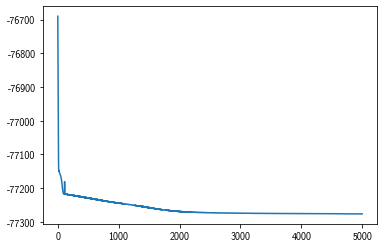

In [102]:
plt.plot(loss_val)

INFO (theano.gof.compilelock): Refreshing lock /Users/rluger/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock


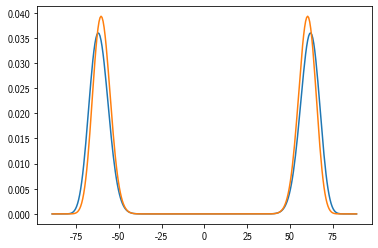

In [103]:
x = np.linspace(-89, 89, 300)
pdf = StarryProcess(latitude=[la.get_value(), lb.get_value()]).latitude.pdf(x).eval()
pdf_true = StarryProcess(latitude=[truth["la"], truth["lb"]]).latitude.pdf(x).eval()
plt.plot(x, pdf)
plt.plot(x, pdf_true)

In [104]:
best_params[5]

array([65.23740205, 41.18994859, 78.77521135, 70.55534195, 73.35384234,
       83.26612133, 81.25056784, 66.12506569, 65.89061464, 57.16092408])

In [105]:
truth["incs"]

array([65.35328356, 43.91872228, 89.99344681, 72.40224316, 81.56102781,
       84.70184091, 79.26538567, 69.78397162, 66.62374742, 57.39687492])

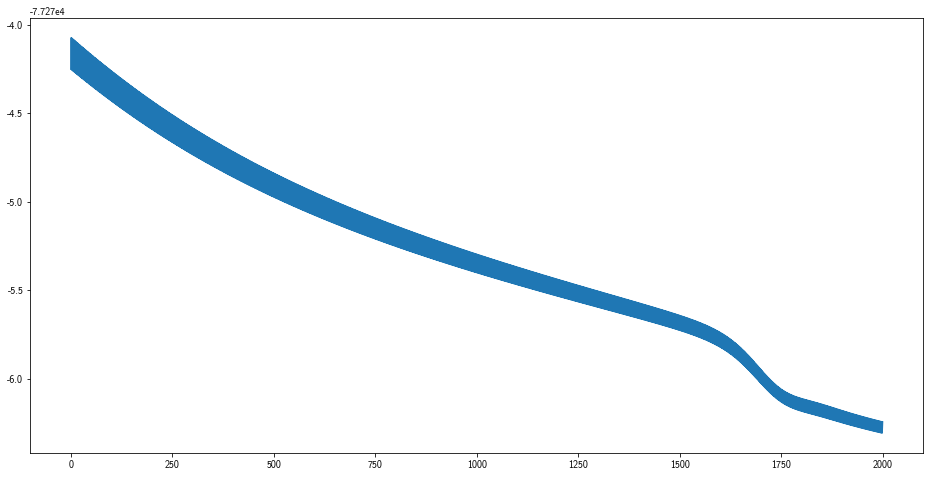

In [109]:
plt.figure(figsize=(16, 8))
plt.plot(loss_val[3000:])